# Evalutation statistique : régression logistique
## Library

In [11]:
import numpy as np
import pandas as pd
from sas7bdat import SAS7BDAT

import matplotlib.pyplot as plt
import seaborn as sns

import math
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

## DataFrame

In [12]:
file_path = 'individus_ct2013.sas7bdat'
with SAS7BDAT(file_path) as reader:
    df = reader.to_data_frame()
df.info()

[individus_ct2013.sas7bdat] column count mismatch
[individus_ct2013.sas7bdat] [individus_ct2013.sas7bdat] column count mismatch


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 139.0+ MB


## Périmètre de l'étude
* On s'intérresse uniquement aux individus vivant en couple dans le même logement. 

In [13]:
df = df.query('COUPLE == "1"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 99.3+ MB


## Variable dépendante binaire
* Créeation d'une variable binaire pour indiquer si la femme est le principal apporteur de ressources
    - [PRACT = 1] == (Oui, l'enquêté est le principal apporteur)
    - [SEXE = 2] == (Femme)

In [14]:

# Créer la nouvelle colonne 'femme_principal_apporteur' avec des valeurs 1 ou 0
df['FPA'] = df.apply(lambda row: 1 if (row['PRACT'] == '1' and row['SEXE'] == '2') else 0, axis=1)

# Compter le nombre de lignes où 'femme_principal_apporteur' est égal à 1
nb_FPA = df['FPA'].sum()

print("Nombre de lignes où 'femme_principal_apporteur' est égal à", nb_FPA)

Nombre de lignes où 'femme_principal_apporteur' est égal à 5080


## Préparation des données *(valeurs manquantes et traitement)*
* Sélectionner des variables indépendantes

#### Critères de Sélection des Variables
Pour choisir les variables explicatives, vous pouvez considérer plusieurs critères :

Corrélations avec la variable dépendante : Utilisez des tests statistiques ou des tableaux de contingence pour identifier les variables qui montrent des relations significatives avec PRACT.

Éviter la multicollinéarité : Assurez-vous que les variables explicatives ne sont pas fortement corrélées entre elles, car cela peut biaiser les estimations de votre modèle.

#### Méthodes de Sélection des Variables
Analyse exploratoire : Utilisez des techniques d'analyse exploratoire des données telles que des graphiques et des tableaux récapitulatifs pour comprendre la distribution des variables et leurs relations avec la variable dépendante.

Tests statistiques : Effectuez des tests statistiques appropriés pour évaluer l'association entre chaque variable explicative potentielle et la variable dépendante. Par exemple, pour les variables continues, vous pouvez utiliser des tests tels que le test t de Student, et pour les variables catégorielles, des tests comme le test du χ² peuvent être appropriés.

Analyse de corrélation : Utilisez des mesures de corrélation (par exemple, le coefficient de corrélation de Pearson) pour évaluer les relations linéaires entre les variables continues.

Analyse de variance : Pour les variables catégorielles, examinez les différences de moyennes entre les groupes définis par chaque catégorie par rapport à la variable dépendante.

In [15]:
variables_dict = {
    'target': ['FPA'],
    'etat_civil_familial': ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E'],
    'situation_travail': ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'SSECH', 'METIER',],
    'revenus_conditions_vie': ['REVMENUC', 'AIDFAM'], 
    'caracteristiques_logement_familial': ['TYPOLOG', 'TYPMEN15', 'NBENFM3', 'NBENF3A17', 'NBENF18P', 'NPERS', 'NACTIFS']
}

# Accès aux listes individuelles
print("* Etat civil et familial:", variables_dict['etat_civil_familial'])
print("* Situation travail:", variables_dict['situation_travail'])
print("* Revenus et conditions de vie:", variables_dict['revenus_conditions_vie'])
print("* Caractéristiques du logement et familial:", variables_dict['caracteristiques_logement_familial'])

* Etat civil et familial: ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E']
* Situation travail: ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'SSECH', 'METIER']
* Revenus et conditions de vie: ['REVMENUC', 'AIDFAM']
* Caractéristiques du logement et familial: ['TYPOLOG', 'TYPMEN15', 'NBENFM3', 'NBENF3A17', 'NBENF18P', 'NPERS', 'NACTIFS']


In [16]:
#explicatives = ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E',                                      #Filtrage du df sur les 25 variables sélectionnées 'manuellement'
#               'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'SSECH', 'METIER',
#               'REVMENUC', 'AIDFAM',
#               'TYPOLOG', 'TYPMEN15', 'NBENFM3', 'NBENF3A17', 'NBENF18P', 'NPERS', 'NACTIFS',
#               ] 

## Exploration des données
* Exploration des données (utiliser des tableaux de contingence pour explorer les relations entre la variable dépendante et les variables explicatives)
* Visualisations (histogrammes, diagramme en baree etc..) pour comprendre la distribution

numerical values: ['FPA', 'ANAIS', 'REVMENUC', 'NBENFM3', 'NBENF3A17', 'NBENF18P', 'NPERS', 'NACTIFS']
categorical_values: ['ETAMATRI', 'PACS', 'MER1E', 'PER1E', 'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'SSECH', 'METIER', 'AIDFAM', 'TYPOLOG', 'TYPMEN15']


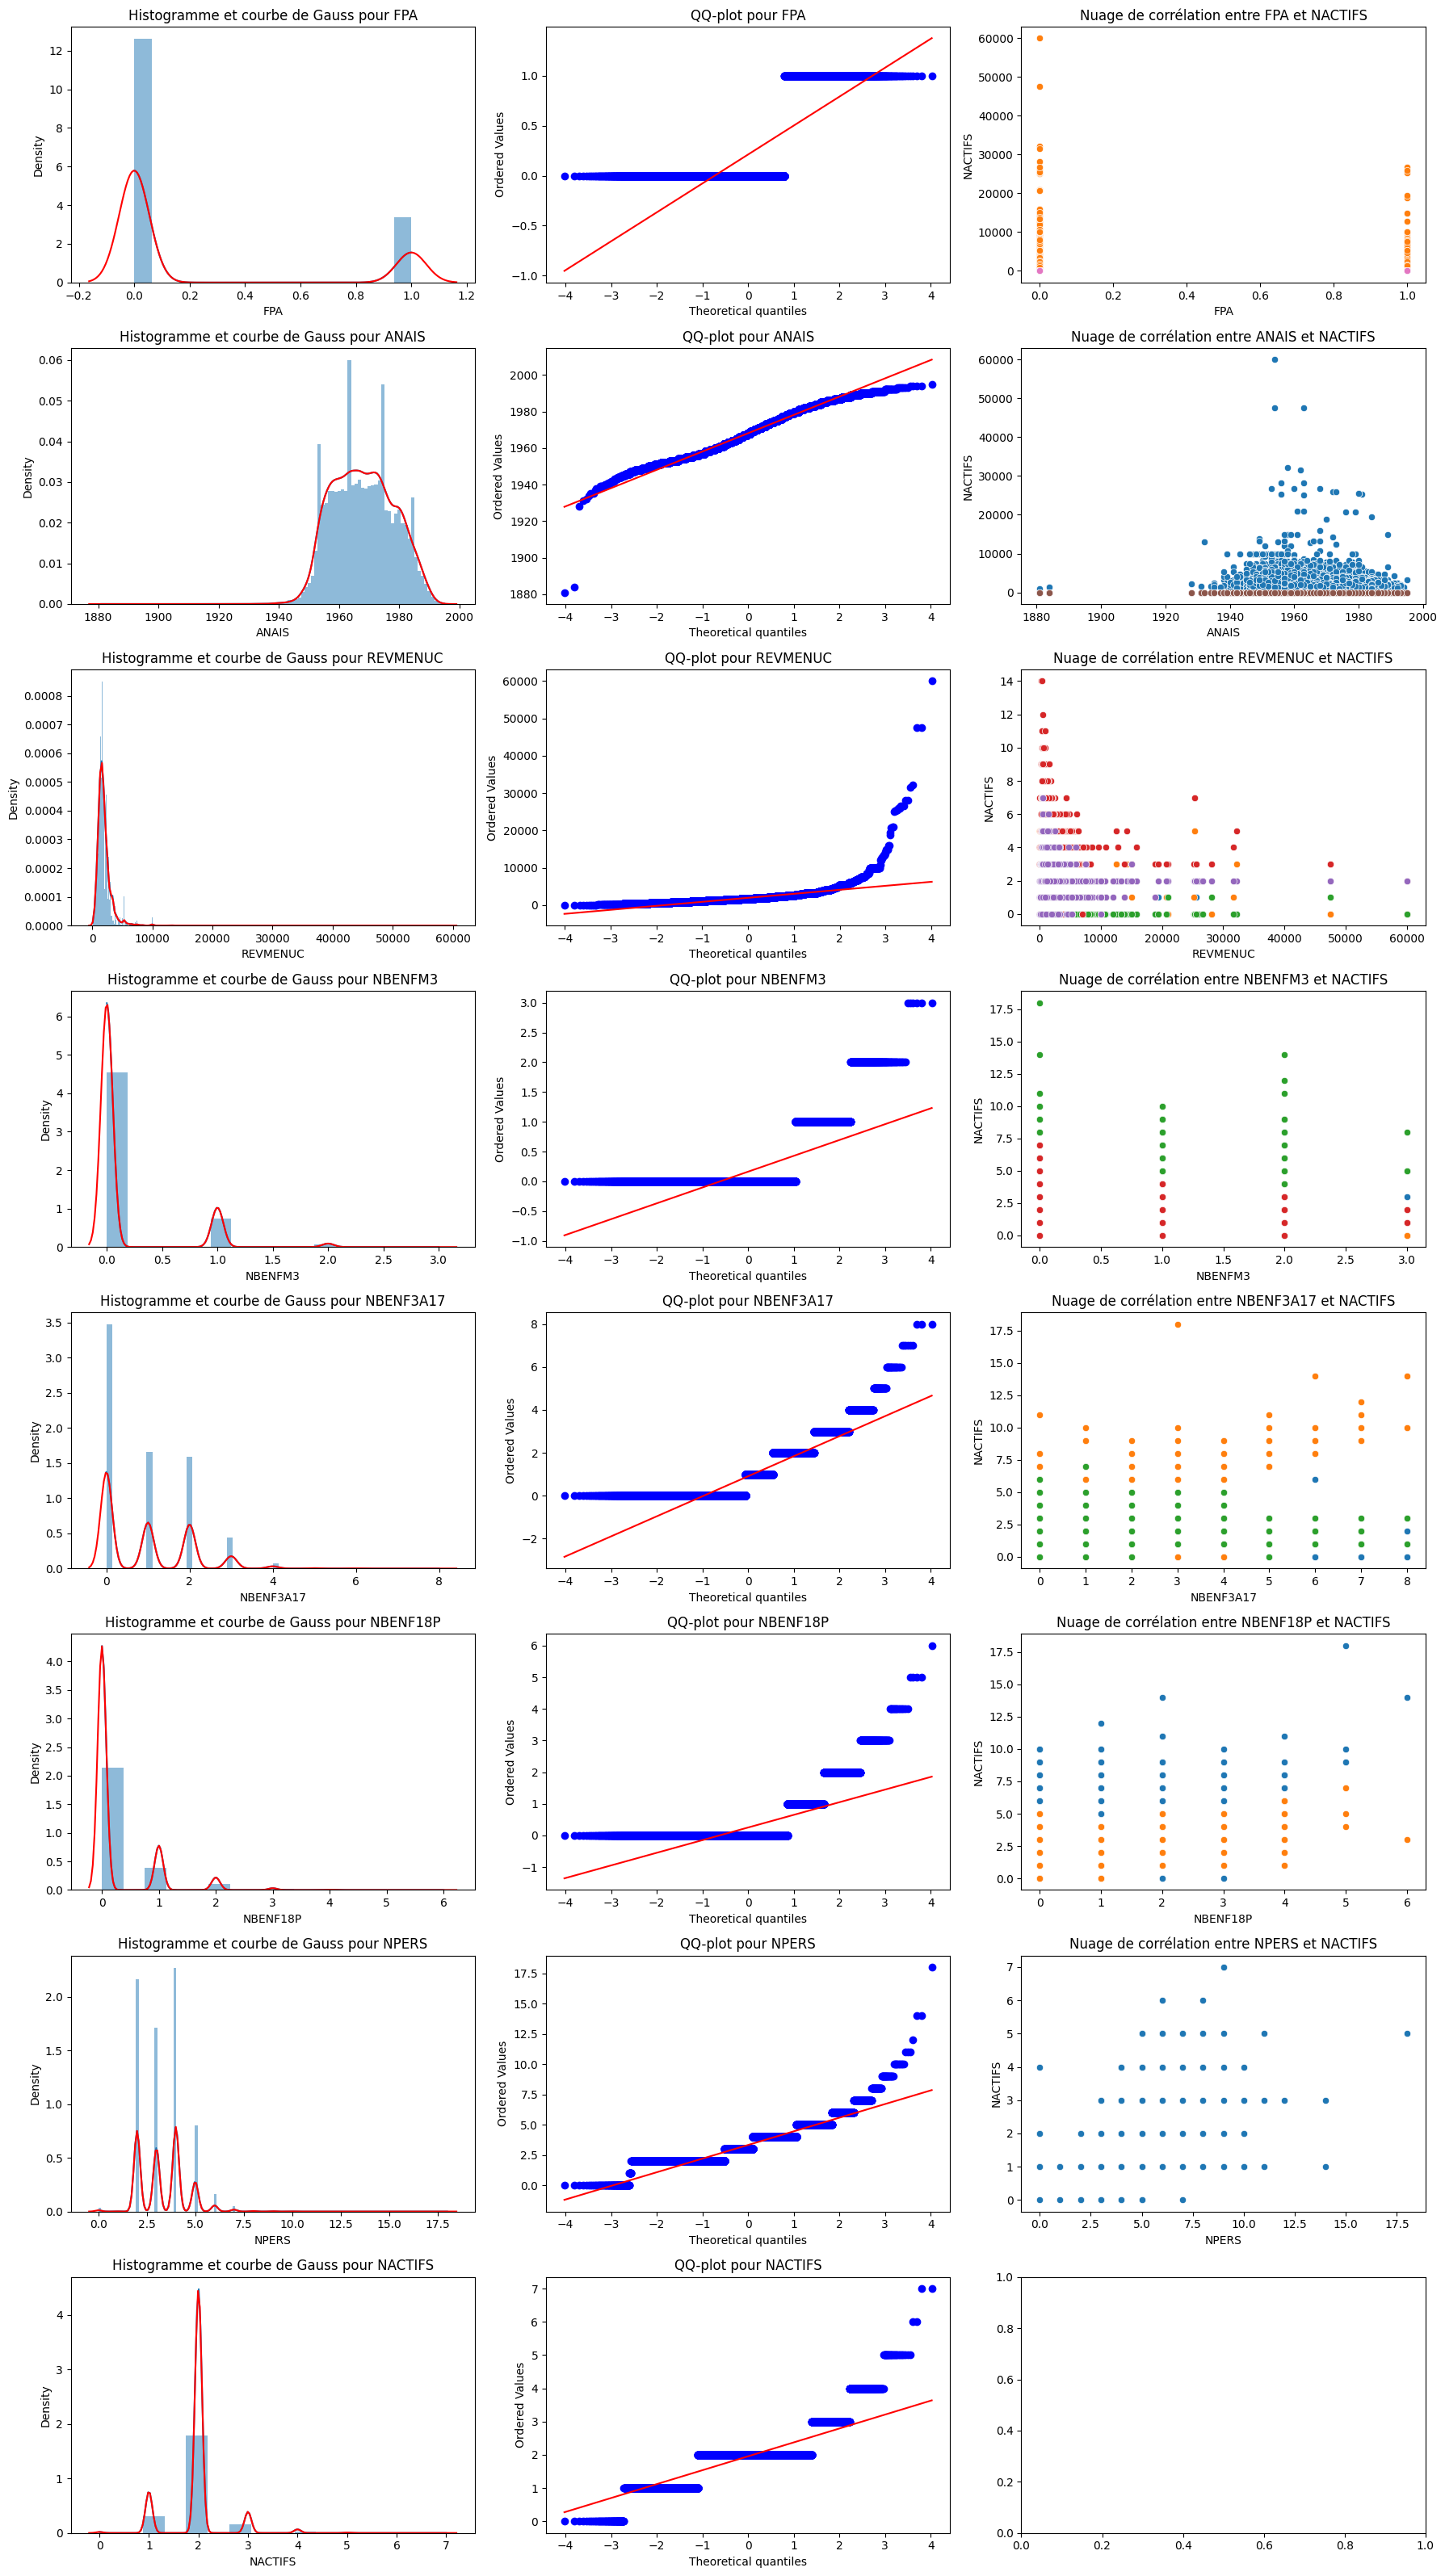

IndexError: index 14 is out of bounds for axis 0 with size 14

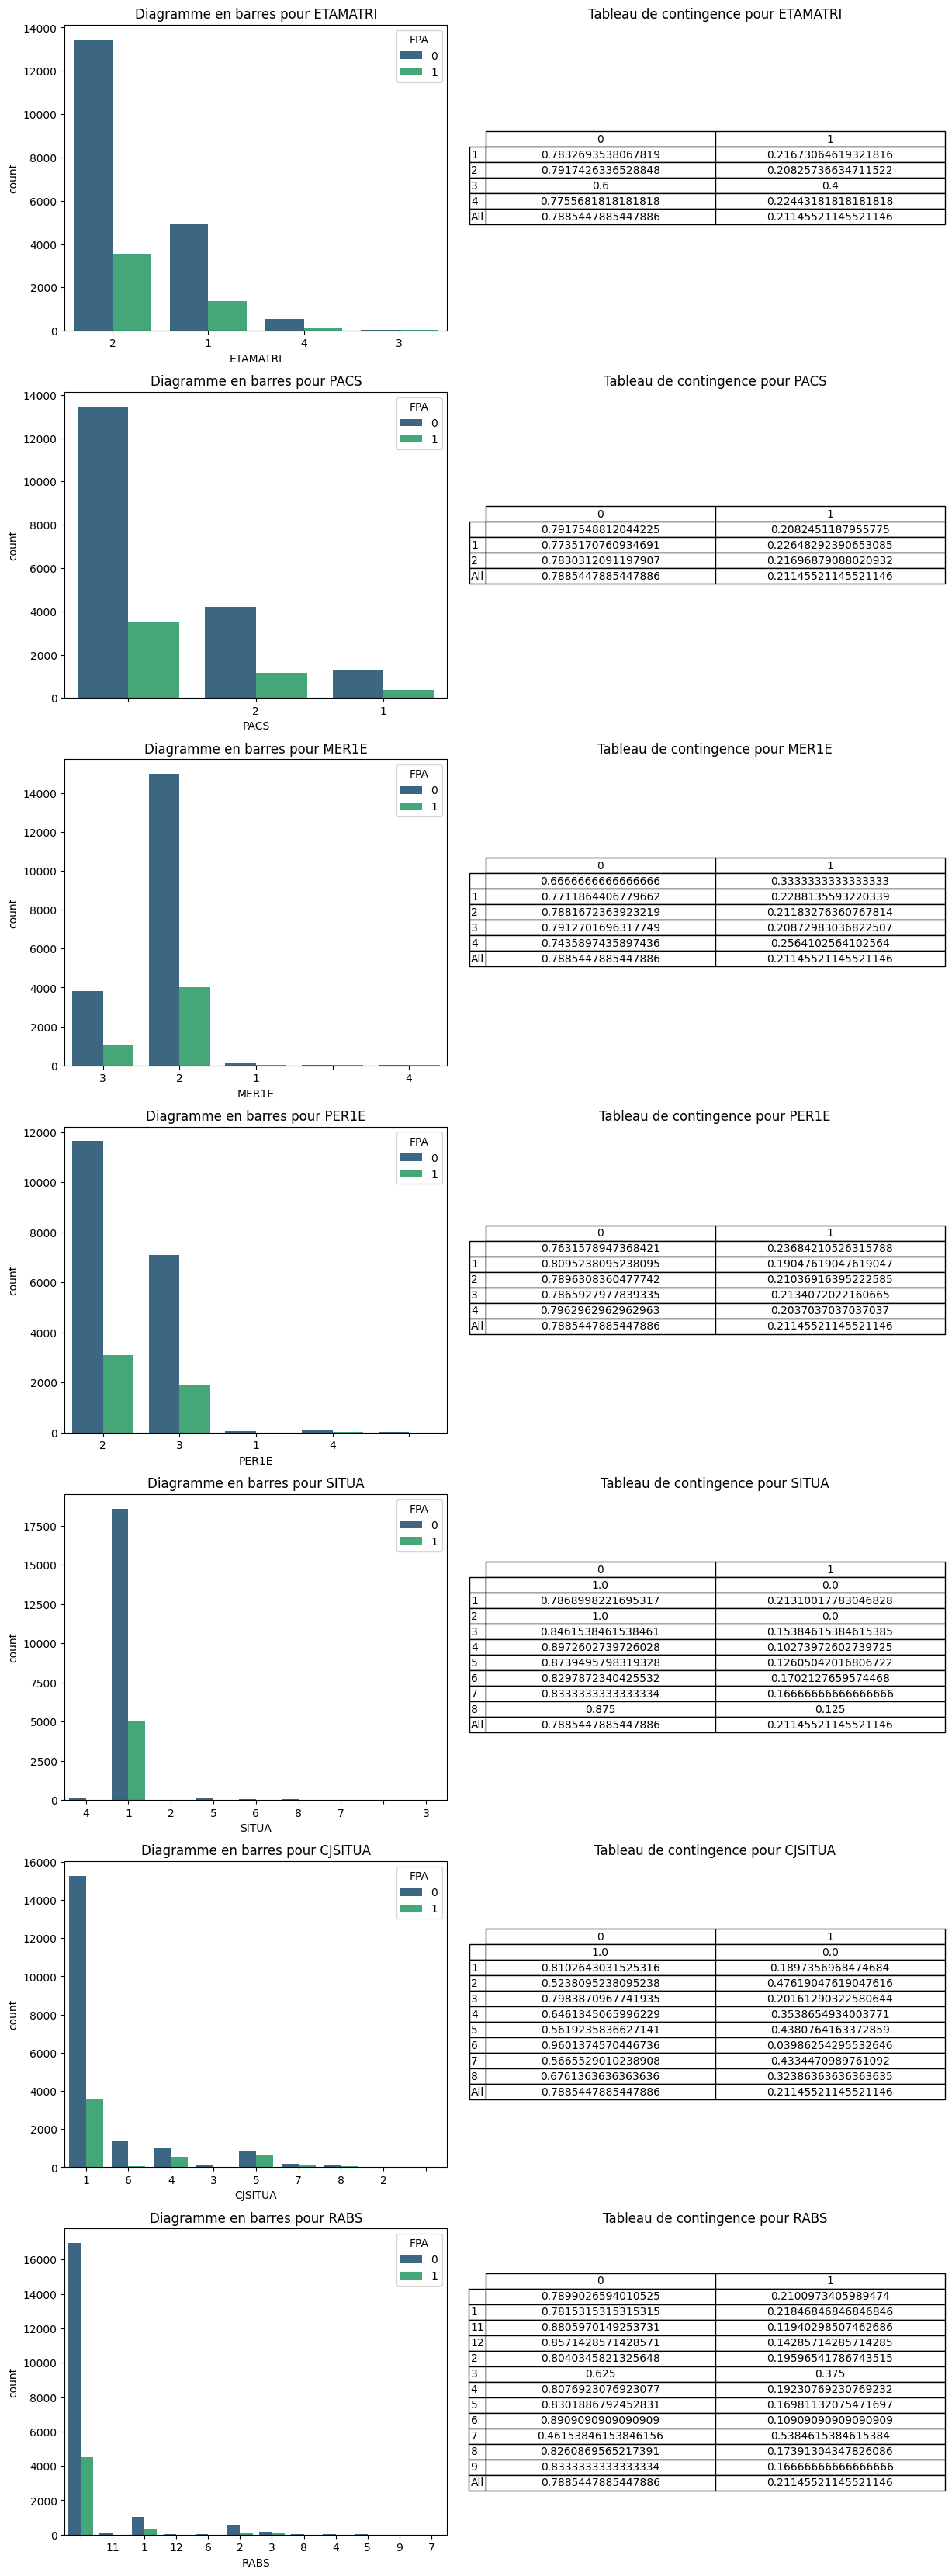

In [21]:
def explore_data(df, variables_dict, target_variable='FPA'):

    # Trier les variables explicatives en numériques et catégorielles
    explicatives = [var for sublist in variables_dict.values() for var in sublist]
    numeric_vars = [var for var in explicatives if pd.api.types.is_numeric_dtype(df[var]) or pd.api.types.is_datetime64_any_dtype(df[var])]
    categorical_vars = [var for var in explicatives if isinstance(df[var].dtype, pd.CategoricalDtype) or df[var].dtype == 'object']
    print(f"numerical values: {numeric_vars}")
    print(f"categorical_values: {categorical_vars}")
    
    # Plot numeric variables
    if numeric_vars:
        num_cols = 3
        num_rows = math.ceil(len(numeric_vars) * 3 / num_cols)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
        axes = axes.flatten()
        
        for i, var in enumerate(numeric_vars):
            # 1. Histogramme et courbe de Gauss
            sns.histplot(df[var], kde=True, stat="density", linewidth=0, ax=axes[i * 3])
            sns.kdeplot(df[var], color='red', ax=axes[i * 3])
            axes[i * 3].set_title(f"Histogramme et courbe de Gauss pour {var}")
            
            # 2. QQ-plot
            stats.probplot(df[var].dropna(), dist="norm", plot=axes[i * 3 + 1])
            axes[i * 3 + 1].set_title(f"QQ-plot pour {var}")
            
            # 3. Nuage de corrélation avec la variable cible
            if len(numeric_vars) > 1:  # Si on a plus d'une variable numérique, faire un nuage de corrélation
                for j in range(i + 1, len(numeric_vars)):
                    sns.scatterplot(x=df[var], y=df[numeric_vars[j]], ax=axes[i * 3 + 2])
                    axes[i * 3 + 2].set_title(f"Nuage de corrélation entre {var} et {numeric_vars[j]}")
                    axes[i * 3 + 2].set_xlabel(var)
                    axes[i * 3 + 2].set_ylabel(numeric_vars[j])
        
        plt.tight_layout()
        plt.show()    
    
    # Plot categorical variables
    if categorical_vars:
        num_cols = 2
        num_rows = math.ceil(len(categorical_vars) / num_cols)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 6))
        axes = axes.flatten()
        
        for i, var in enumerate(categorical_vars):
            # 1. Diagramme en barres
            sns.countplot(x=var, data=df, palette="viridis", ax=axes[i * 2], hue=target_variable)  # Utilisation de hue avec la variable cible
            axes[i * 2].set_title(f"Diagramme en barres pour {var}")
            
            # 2. Tableau de contingence
            contingency_table = pd.crosstab(df[var], df[target_variable], margins=True, normalize='index')
            axes[i * 2 + 1].axis('off')  # désactiver l'affichage de l'axe pour le tableau de contingence
            table = axes[i * 2 + 1].table(cellText=contingency_table.values, colLabels=contingency_table.columns, rowLabels=contingency_table.index, cellLoc='center', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.2)
            axes[i * 2 + 1].set_title(f"Tableau de contingence pour {var}")
        
        plt.tight_layout()
        plt.show()


explicatives = [var for sublist in variables_dict.values() for var in sublist] #Filtrage du df sur les 25 variables sélectionnées 'manuellement'
df_filtered = df[explicatives].copy()

explore_data(df_filtered, variables_dict)

## Modélisation
* Régression logistique pour modéliser la probabilité qu'une femme soit le principal apporteur de ressources du ménage. 
* Evaluation et diagnostique du modele
* Interprétation des résultats

In [ ]:
# Préparation des données pour la régression logistique
X = df[explicatives]
y = df['FPA']

# Ajout d'une constante pour l'interception
X = sm.add_constant(X)

# Régression logistique avec statsmodels
model = sm.Logit(y, X)
result = model.fit()

# Résumé du modèle
print(result.summary())

# Préparation des données pour sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Régression logistique avec sklearn
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Prédictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

# Évaluation du modèle
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('AUC: ', roc_auc_score(y_test, y_prob))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).